# Watermarking



## Adversarial Setting

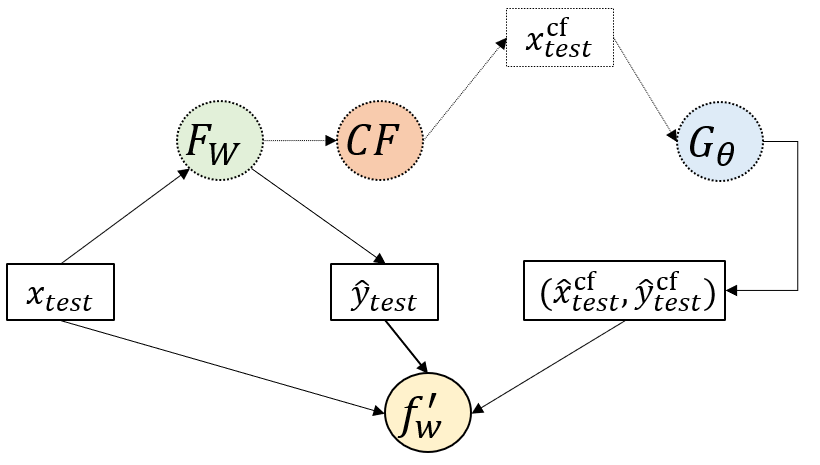

Notations:

* $F_W$: original model 
* $x_{test}$: test queries from real users or adversaries
* $\hat{y}_{test}$: returned output of $x_{test}$, where $\hat{y}_{test} = F_W(x_{test})$
* $CF$: CF algorithm
* $x^\text{cf}_{test}$: the CF explanation of $x_{test}$, where $x^\text{cf}_{test}=CF(x_{test}, F_W)$
* $G_\theta$: watermarking algorithm
* $\hat{x}^\text{cf}_{test}$: watermarked counterfactual explanation

The dashed componenets are hidden from the adversary. 

Accessible: $(x_{test}, \hat{y}_{test}, \hat{x}^\text{cf}, \hat{y}^\text{cf})$

NOT Accessible: Original model $F_W$, CF algorihtm $CF$, 
unwatermarked counterfactuals $\hat{x}^\text{cf}$,
watermarking method: $G_\theta$

Aim: $f_w \to F_W$

## Defense

Step One: watermark counterfactual $\hat{x}^\text{cf} = G({x}^\text{cf}; \theta)$

Step Two: perform hypothesis testing to detect models trained on watermarked counterfactuals

### 1. Watermarking

The purpose is to have a watermarking function $G(\cdot; \theta)$, s.t., $p_{\hat{x}} - p{x} > b$.

\begin{align*}
&\max_{\theta} \sum_{(x,y) \in D^\text{cf}} KL \left[ f_{w^*}(G(x; \theta)), f_{w^*}(x) \right] - KL \left[ F_W(G(x; \theta)), F_W(x) \right], \\
&\text{s.t.} \quad w^* = \arg\min_{w} \sum_{(x,y) \in D} \mathcal{L}(f_w(x), y) 
+ \sum_{(x,y) \in D^\text{cf}} \mathcal{L}(f_w(G(x; \theta^*)), y)
\end{align*}

where 
$D =\{(x, y)_p\}$,
$D^\text{cf} =\{(x^{\text{cf}}, y^{\text{cf}})_p\}$.

Problems:

1. Watermarked counterfactuals might not be valid (i.e., $F(G(x^\text{cf}; \theta)) = F(x^\text{cf})$)
2. $|| G(x^\text{cf}; \theta) - x^\text{cf} ||_1$ might be large

Solution:

1. The formulation now should ensure the validity of counterfactuals
2. We can add an constraint (e.g., $G(x) = x+\theta$, where $|\theta| < \delta$)

#### [Deprecated!!! This is wrong] Reduction

I think the current formulation can be reduced to only two objectives:

\begin{align*}
&\max_{\theta} \sum_{(x,y) \in D^\text{cf}} KL \left[ f_{w^*}(G(x; \theta)), f_{w^*}(x) \right], \\
&\text{s.t.} \quad w^* = \arg\min_{w} \sum_{(x,y) \in D} \mathcal{L}(f_w(x), y) 
+ \sum_{(x,y) \in D^\text{cf}} \mathcal{L}(f_w(G(x; \theta^*)), F_W(x))
\end{align*}


### 2. Detection

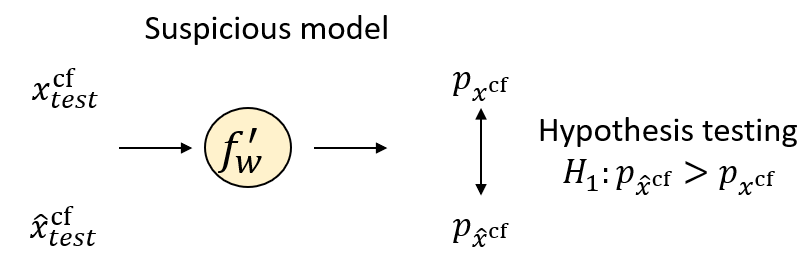

In [ ]:
#|default_exp watermark

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from __future__ import annotations
import relax
from relax.utils import *
from relax.methods import *
from relax import DataModule
from relax.import_essentials import *
from relax.evaluate import compute_proximity, compute_validity
from relax.ml_model import MLModule
from relax.explain import Explanation, prepare_cf_module
from relax.data_module import DEFAULT_DATA
from relax.methods.l2c import *
import einops
from einops import rearrange, reduce, repeat
from keras.random import SeedGenerator
import copy
import keras.losses as L
from jax_tqdm import scan_tqdm
import jax.tree_util as jt

# jax.config.update("jax_enable_x64", False)
# jax.config.update("jax_enable_x64", True)
jax.devices()

[cuda(id=0)]

In [ ]:
#| export
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator

In [ ]:
#| export
from relax.legacy.module import PredictiveModelConfigs, hk, MLP
from relax.legacy.utils import make_hk_module

In [ ]:
xs, ys = make_classification(10_000, n_features=10, random_state=np.random.RandomState(0))
dm = relax.DataModule.from_numpy(xs, ys)
ml_module = relax.MLModule().train(dm, epochs=50, batch_size=32, verbose=0)

In [ ]:
model = ml_module.model

In [ ]:
# dm = relax.load_data('dummy')
# ml_module = relax.load_ml_module('dummy')
# model = ml_module.model

In [ ]:
dcf = DiverseCF({'lambda_2': 4})
exp = relax.generate_cf_explanations(
    dcf, dm, ml_module.pred_fn
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#| export
class DenseBlock(hk.Module):
    """A `DenseBlock` consists of a dense layer, followed by Leaky Relu and a dropout layer."""
    
    def __init__(
        self,
        output_size: int,  # Output dimensionality.
        dropout_rate: float = 0.3,  # Dropout rate.
        name: str | None = None,  # Name of the Module
    ):
        super().__init__(name=name)
        self.output_size = output_size
        self.dropout_rate = dropout_rate

    def __call__(self, x: jnp.ndarray, is_training: bool = True) -> jnp.ndarray:
        dropout_rate = self.dropout_rate if is_training else 0.0
        # he_uniform
        w_init = hk.initializers.VarianceScaling(2.0, "fan_in", "uniform")
        x = hk.Linear(self.output_size, w_init=w_init)(x)
        x = jax.nn.leaky_relu(x, negative_slope=0.2) # Default by keras to 0.2
        x = hk.dropout(hk.next_rng_key(), dropout_rate, x)
        return x

class MLP(hk.Module):
    """A `MLP` consists of a list of `DenseBlock` layers."""
    
    def __init__(
        self,
        sizes: Iterable[int],  # Sequence of layer sizes.
        dropout_rate: float = 0.3,  # Dropout rate.
        name: str | None = None,  # Name of the Module
    ):
        super().__init__(name=name)
        self.sizes = sizes
        self.dropout_rate = dropout_rate

    def __call__(self, x: jnp.ndarray, is_training: bool = True):
        for size in self.sizes:
            x = DenseBlock(size, self.dropout_rate)(x, is_training)
        return x


class PredictiveModel(hk.Module):
    """A basic predictive model for binary classification."""
    
    def __init__(
        self,
        sizes: List[int], # Sequence of layer sizes.
        dropout_rate: float = 0.3,  # Dropout rate.
        name: Optional[str] = None,  # Name of the module.
    ):
        """A basic predictive model for binary classification."""
        super().__init__(name=name)
        self.sizes = sizes
        self.dropout_rate = dropout_rate

    def __call__(self, x: jnp.ndarray, is_training: bool = True):
        x = MLP(self.sizes, self.dropout_rate)(x, is_training)
        x = hk.Linear(2)(x)
        x = jax.nn.softmax(x)
        return x


In [ ]:
#| export
def keras2haiku(
    model: keras.Model,
    config: relax.ml_model.MLModuleConfig,
    input_shape: Tuple[int, ...]
) -> Union[hk.Transformed, hk.Params]: 
    """Convert a keras model to a haiku model."""
    
    net = make_hk_module(
        PredictiveModel, 
        sizes=config.sizes, 
        dropout_rate=config.dropout_rate
    )
    params = net.init(jax.random.PRNGKey(0), jnp.ones(input_shape), is_training=True)
    # copy weights from keras model
    weights = iter(model.weights)
    for k, v in params.items():
        w = next(weights).value
        b = next(weights).value
        if v['w'].shape == w.shape:
            v['w'] = w
        else: 
            raise ValueError(f"shape mismatch: {v['w'].shape} != {w.shape}")
        if v['b'].shape == b.shape:
            v['b'] = b
        else:
            raise ValueError(f"shape mismatch: {v['b'].shape} != {b.shape}")
    return net, params

In [ ]:
pred_model, pred_params = keras2haiku(model, ml_module.config, dm.xs[:1].shape)

In [ ]:
assert np.allclose(
    pred_model.apply(pred_params, jrand.PRNGKey(0), dm.xs[:1], is_training=False),
    model.predict(dm.xs[:1])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


\begin{align*}
&\max_{\theta} \sum_{(x,y) \in D^\text{cf}} log\left(\frac{f_{w^*}(G(x; \theta))}{f_{w^*}(x)}\right)  - KL \left[ F_W(G(x; \theta)), F_W(x) \right], \\
&\text{s.t.} \quad w^* = \arg\min_{w} \sum_{(x,y) \in D} \mathcal{L}(f_w(x), y) 
+ \sum_{(x,y) \in D^\text{cf}} \mathcal{L}(f_w(G(x; \theta^*)), y)
\end{align*}

where 
$D =\{(x, y)_p\}$,
$D^\text{cf} =\{(x^{\text{cf}}, y^{\text{cf}})_p\}$.

In [ ]:
#| export
def hard_kl_divergence(y_true, y_pred):
    """
    Formula:
    ```python
    loss = y_true * log(y_true / y_pred)
    ```
    """

    y_true = jnp.clip(y_true, 1e-7, 1)
    y_pred = jnp.clip(y_pred, 1e-7, 1)
    
    return (
        y_true.round() * jnp.log(y_true / y_pred)
    ).sum(axis=-1)

\begin{align*}
&\max_{\theta} \sum_{(x,y) \in D^\text{cf}} log\left(\frac{f_{w^*_1}(G(x; \theta))}{f_{w^*_1}(x)}\right)  - KL \left[ F_W(G(x; \theta)), F_W(x) \right] - log\left(\frac{f_{w^*_2}(G(x; \theta))}{f_{w^*_2}(x)}\right), \\
&\text{s.t.} \quad w^*_1 = \arg\min_{w_1} \sum_{(x,y) \in D} \mathcal{L}(f(x;w_1), y) 
+ \sum_{(x,y) \in D^\text{cf}} \mathcal{L}(f(G(x; \theta^*); w_1), y), \\
&\quad w^*_2 = \arg\min_{w_2} \sum_{(x,y) \in D} \mathcal{L}(f(x;w_2), y),
\end{align*}

where 
$D =\{(x, y)_p\}$,
$D^\text{cf} =\{(x^{\text{cf}}, y^{\text{cf}})_p\}$.

In [ ]:
#| export
@ft.partial(jax.jit, static_argnums=(3, 6, 8, 9,13, 14, 15, 16))
def watermark(
    x: jax.Array, # original sample (B, K)
    y: jax.Array, # original label (B, 1)
    cf: jax.Array, # counterfactual (B, C, K)
    net,
    params: hk.Params,
    lr: float,
    steps: int,
    step_size: float, # 2.5 * eps / steps
    k: int,
    n_ensembels: int,
    lambdas: tuple[float, float, float],
    rng_key: jax.random.PRNGKey,
    train_xs: jax.Array,
    init_fn: Callable,
    proj_fn: Callable, # project function for delta
    apply_constraints: Callable, # apply constraints to the counterfactual
    use_train_data: bool = True,
):
        
    def forward(weights, key, xs, is_training):
        return jax.vmap(net.apply, in_axes=(0, None, None, None))(
            weights, key, xs, is_training
        )
    
    def vapply_constraints(cf, hard, rng_key):
        cf = einops.rearrange(cf, '(B C) K -> B C K', **x_shape)
        rng_keys = jnp.broadcast_to(rng_key, (cf.shape[1], 2))
        cf = jax.vmap(apply_constraints, in_axes=(None, 1, None, 0), out_axes=1)(
            x, cf, hard, rng_keys)
        return einops.rearrange(cf, 'B C K -> (B C) K', **x_shape)

    @jax.jit
    def inner_fn(weights, batch, key):
        xs, ys = batch
        # f_w, adv model
        y_pred = net.apply(weights, key, xs, is_training=True)
        loss = L.binary_crossentropy(ys, y_pred).mean()
        return loss

    @ft.partial(jax.jit, static_argnums=(6,))
    def bilevel_fn(delta, new_params, old_params, opt_state, key, batch, opt):
        def inner_step_fn(i, state):
            """inner steps"""

            delta, params, opt_state, key = state
            new_params_1, new_params_2 = params
            key_1, key_2, key_3, next_key = jrand.split(key, 4)

            w_cf = vapply_constraints(cf + delta, hard=False, rng_key=key_1)
            batch_size = cf.shape[0]
            # use more data for training for improved generalization
            # more_train_xs = train_xs[i * batch_size: (i + 1) * batch_size]
            if use_train_data:
                more_train_xs = jax.lax.dynamic_slice(
                    train_xs, (i * batch_size, 0), (batch_size, train_xs.shape[-1]))
            else:
                more_train_xs = jnp.zeros((0, x.shape[-1]))
            xs = jnp.concatenate([x, more_train_xs, w_cf])
            # xs = jnp.concatenate([w_cf])
            ys = net.apply(old_params, jrand.PRNGKey(0), xs, is_training=False)

            # regularize 
            xs_input = jnp.concatenate([x, more_train_xs, ])
            ys_input = net.apply(old_params, jrand.PRNGKey(0), xs_input, is_training=False)
            # TODO: when params equals to old_params, the gradient is zero (seems okay)
            loss, g_1 = jax.vmap(jax.value_and_grad(inner_fn), (0, None, None))(new_params_1, (xs, ys), key_2)
            loss, g_2 = jax.vmap(jax.value_and_grad(inner_fn), (0, None, None))(new_params_2, (xs_input, ys_input), key_3)
            # clip very small gradients to avoid nan
            g = jax.tree_map(
                lambda x: jnp.where(
                    jnp.abs(x) < 1e-8, jnp.zeros_like(x), x), (g_1, g_2))
            
            # g = (g_1, jax.tree_util.tree_map(lambda x: jnp.zeros_like(x), g))
            params, opt_state = grad_update(g, params, opt_state, opt)
            return delta, params, opt_state, next_key
    
        x, y, cf = batch
        
        # inner problem
        delta, new_params, opt_state, key = jax.lax.fori_loop(
            0, k, inner_step_fn, (delta, new_params, opt_state, key))

        new_params_1, new_params_2 = new_params
        # outer problem
        key, next_key = jrand.split(key)
        w_cf = vapply_constraints(cf + delta, hard=False, rng_key=key)
        w_cf_y_upt_1 = forward(new_params_1, jrand.PRNGKey(0), w_cf, is_training=False)
        cf_y_upt_1 = forward(new_params_1, jrand.PRNGKey(0), cf, is_training=False)
        _cf_y_old = net.apply(old_params, jrand.PRNGKey(0), w_cf, is_training=False)
        cf_y_old = net.apply(old_params, jrand.PRNGKey(0), cf, is_training=False)
        w_cf_y_upt_2 = forward(new_params_2, jrand.PRNGKey(0), w_cf, is_training=False)
        cf_y_upt_2 = forward(new_params_2, jrand.PRNGKey(0), cf, is_training=False)
        
        # loss functions
        poison_loss = hard_kl_divergence(w_cf_y_upt_1, cf_y_upt_1).mean()
        validity_loss = L.kl_divergence(_cf_y_old, cf_y_old).mean()
        reg_loss = hard_kl_divergence(w_cf_y_upt_2, cf_y_upt_2).mean()
        # loss = (poison_loss - validity_loss)
        loss = (lambda_1 * poison_loss - lambda_2 * validity_loss - lambda_3 * reg_loss)
        return loss, (new_params, opt_state, next_key, (poison_loss, validity_loss, reg_loss))
        
    @scan_tqdm(steps)
    def step_fn(state, i):
        delta, params, old_params, opt_state, key = state
        ((_, (params, opt_state, key, loss)), g) = jax.value_and_grad(
            bilevel_fn, has_aux=True)(
                delta, params, old_params, opt_state, key, (x, y, cf), opt) # ((value, auxiliary_data), gradient)
        # print("loss: ", loss)

        # delta = delta + (2.5 * eps / steps) * jnp.sign(g)
        # TODO: 1. use adam; 2. step_size might be too small for categorical feats
        delta = delta + step_size * jnp.sign(g) 
        # delta = jnp.clip(delta, -eps, eps)
        delta = proj_fn(delta)

        # reinit params
        key, reinit_key = jrand.split(key)
        # params = reinit_params(params, reinit_key, x[:1])
        return (delta, params, old_params, opt_state, key), loss

    # reshape x and cf
    x_shape = einops.parse_shape(x, 'B K')
    cf = einops.rearrange(cf, 'B C K -> (B C) K', **x_shape)
    # split keys
    rng_key, init_delta_key, init_params_key = jrand.split(rng_key, 3)
    # init delta
    # delta = jrand.uniform(jrand.PRNGKey(0), shape=cf.shape, minval=-eps, maxval=eps)
    delta = init_fn(init_delta_key, cf.shape)
    # delta = jnp.zeros_like(cf)
    # init params
    # old_params = copy.deepcopy(params)
    old_params = params
    keys = jrand.split(init_params_key, n_ensembels)
    new_params = tuple(jax.vmap(net.init, in_axes=(0, None, None))(keys, x[:1], True) for _ in range(2))
    opt = optax.adam(lr)
    opt_state = opt.init(new_params)
    lambda_1, lambda_2, lambda_3 = lambdas
    
    # new_params = net.init(jrand.PRNGKey(0), x[:1], is_training=True)
    # new_params = params
    state = (delta, new_params, old_params, opt_state, rng_key)
    (delta, new_params, old_params, opt_state, key), loss = jax.lax.scan(
        step_fn, state, jnp.arange(steps)
    )
    cf = vapply_constraints(cf + delta, True, key)
    cf = einops.rearrange(cf, '(B C) K -> B C K', **x_shape)
    return cf, loss

In [ ]:
def init_fn(key: jrand.PRNGKey, shape: Tuple[int, ...]):
    return jrand.uniform(key, shape=shape, minval=-eps, maxval=eps)

eps = 0.03
# init_fn = lambda key, shape: jrand.uniform(key, shape=shape, minval=-eps, maxval=eps)
proj_fn = ft.partial(jnp.clip, a_min=-eps, a_max=eps)
# apply_constraints = lambda x, cf, hard: jnp.clip(cf, 0., 1.)
apply_constraints_fn = exp.apply_constraints
# partial_watermark = partial(watermark, net=pred_model, params=pred_params, 
#                             lr=0.1, steps=25, step_size=2.5 * eps / 25, k=5, n_ensembels=5, 
#                             rng_key=jrand.PRNGKey(0), train_xs=dm.xs,
#                             init_fn=init_fn, proj_fn=proj_fn, apply_constraints=apply_constraints)

# jax.vmap(partial_watermark)(exp.xs[:2], exp.ys[:2], exp.cfs[:2, :, :])
bs = 32
w_cfs, loss = watermark(
    exp.xs[:bs], exp.ys[:bs], exp.cfs[:bs, :, :],
    net=pred_model, params=pred_params, 
    lr=0.1, steps=25, step_size=2.5 * eps / 25, k=5, n_ensembels=5, 
    rng_key=jrand.PRNGKey(0), train_xs=dm.xs, lambdas=(2, 1, 1),
    init_fn=init_fn, proj_fn=proj_fn, apply_constraints=apply_constraints_fn)
    # train_xs=dm.xs)

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
w_cfs, loss = watermark(
    exp.xs[:bs], exp.ys[:bs], exp.cfs[:bs, :, :],
    net=pred_model, params=pred_params, 
    lr=0.1, steps=25, step_size=2.5 * eps / 25, k=5, n_ensembels=5, 
    rng_key=jrand.PRNGKey(0), train_xs=dm.xs, lambdas=(2, 1, 1),
    init_fn=init_fn, proj_fn=proj_fn, apply_constraints=apply_constraints_fn, use_train_data=False)

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
#| export
def _pad_divisible_xs(xs: Array, n: int):
    """Pad `X` to be divisible by `n`."""
    if xs.shape[0] % n != 0:
        pad_size = n - xs.shape[0] % n
        xs_pad = einops.repeat(
            xs[-1:], "n ... -> (pad n) ...", pad=pad_size
        )
        xs = jnp.concatenate([xs, xs_pad])
    X_padded = xs.reshape(-1, n, *xs.shape[1:])
    return X_padded


In [ ]:
#| export
def get_proj_fn(
    dm: relax.DataModule, 
    eps: float, 
    perturb_categorical: bool = True # If False, set delta of cat features to 0
):
    """Project `X` to be within the range of `dm.xs`."""
    K = dm.xs.shape[-1]
    proj_idx = np.ones(K, dtype=float)
    for feat, (start, end) in dm.features.features_and_indices:
        if feat.is_categorical:
            proj_idx[start:end] = 0.

    @jax.jit
    def _proj_fn(x: jnp.ndarray):
        x = np.clip(x * proj_idx, -eps, eps) + x * (1 - proj_idx)
        return x
    
    if perturb_categorical: return _proj_fn
    else:                   return lambda x: np.clip(x * proj_idx, -eps, eps)

In [ ]:
adult_dm = relax.load_data('adult')
delta = np.ones((2, 29))
proj_fn = get_proj_fn(adult_dm, eps)
proj_delta = proj_fn(delta)
assert jnp.allclose(proj_delta[:, :2], np.ones((2, 2)) * eps)
assert jnp.allclose(proj_delta[:, 2:], np.ones((2, 27)))

proj_fn = get_proj_fn(adult_dm, eps, perturb_categorical=False)
proj_delta = proj_fn(delta)
assert jnp.allclose(proj_delta[:, :2], np.ones((2, 2)) * eps)
assert jnp.allclose(proj_delta[:, 2:], np.zeros((2, 27)))
del adult_dm

In [ ]:
#| export
class WatermarkConfig(BaseParser):

    batch_size: int = 64
    lr: float = 0.1
    steps: int = 50 
    k: int = 10
    eps: float = 0.03
    n_ensembels: int = 8
    alpha: float = 2.5
    lambdas: tuple[float, float, float] = (2.0, 1.0, 1.0)
    use_test_only: bool = True
    use_vmap: bool = True
    use_train_data: bool = True
    random_perturbation: bool = False # baseline: delta ~ U(-eps, eps)
    # return_loss: bool = False
    init: Literal['zeros', 'uniform'] = 'zeros'
    perturb_categorical: bool = True
    seed: int = 0

    @property
    def step_size(self):
        return self.alpha * self.eps / self.steps
    
    @property
    def rng_key(self):
        return jrand.PRNGKey(self.seed)

    @property
    def init_fn(self):
        if self.init == 'zeros':        
            return lambda key, shape: jnp.zeros(shape)
        elif self.init == 'uniform':    
            return lambda key, shape: jrand.uniform(key, shape=shape, minval=-self.eps, maxval=self.eps)
        else:                           
            raise ValueError(f"Unknown init method: {self.init}")
    
    def get_proj_fn(self, dm: relax.DataModule):
        return get_proj_fn(dm, self.eps, self.perturb_categorical)

In [ ]:
#| export
def batched_watermark(
    exp: Explanation,
    conf: WatermarkConfig,
    pred_model: hk.Module, 
    pred_params: hk.Params, 
    return_loss: bool = False
):
    
    xs, ys, cfs = exp.xs, exp.ys, exp.cfs
    if conf.use_test_only:
        xs, ys, cfs = jt.tree_map(lambda arr: arr[jnp.array(exp.test_indices)], (xs, ys, cfs))
    
    if conf.random_perturbation:
        if return_loss: warnings.warn("Random perturbation is used, return None.")
        delta = jrand.uniform(conf.rng_key, shape=cfs.shape, minval=-conf.eps, maxval=conf.eps)
        return cfs + delta, tuple() if return_loss else cfs + delta
    
    xs_pad, ys_pad, cfs_pad = jax.tree_map(
        lambda arr: _pad_divisible_xs(arr, conf.batch_size), (xs, ys, cfs)
    )
    # print(xs_pad.shape, ys_pad.shape, cfs_pad.shape)
    train_xs = exp['train']['xs']
    # TODO: do not consider immutable features
    apply_constraints_fn = exp.apply_constraints if conf.perturb_categorical else lambda x, cf, hard, rng: np.clip(cf, 0., 1.)

    if conf.use_vmap:
        partial_watermark = partial(watermark, net=pred_model, params=pred_params, 
                                    lr=conf.lr, steps=conf.steps, k=conf.k, 
                                    n_ensembels=conf.n_ensembels, step_size=conf.step_size,
                                    rng_key=conf.rng_key, train_xs=train_xs, lambdas=conf.lambdas,
                                    init_fn=conf.init_fn, proj_fn=conf.get_proj_fn(exp), 
                                    apply_constraints=apply_constraints_fn, use_train_data=conf.use_train_data)
        w_cfs, loss = jax.jit(jax.vmap(partial_watermark))(xs_pad, ys_pad, cfs_pad)
    else:
        def partial_watermark(state):
            xs, ys, cfs = state
            return watermark(xs, ys, cfs, pred_model, pred_params, conf.lr, conf.steps, conf.eps, conf.k)
        
        w_cfs, loss = jax.lax.map(partial_watermark, (xs_pad, ys_pad, cfs_pad))
    # w_cfs = jax.vmap(partial_watermark)(xs_pad, ys_pad, cfs_pad)
    if return_loss:
        return w_cfs.reshape(-1, *w_cfs.shape[2:])[:cfs.shape[0]], loss
    else:
        return w_cfs.reshape(-1, *w_cfs.shape[2:])[:cfs.shape[0]]

In [ ]:
args = dict(batch_size=64, steps=50, eps=0.05, k=10, n_ensembels=8)
conf = WatermarkConfig(**args)
w_cfs, loss = batched_watermark(exp, conf, pred_model=pred_model, pred_params=pred_params, return_loss=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Validity loss:

In [ ]:
w_cf_y = pred_model.apply(pred_params, jrand.PRNGKey(0), w_cfs, is_training=False)
cf_y = pred_model.apply(pred_params, jrand.PRNGKey(0), exp.cfs[jnp.array(exp.test_indices)], is_training=False)
        
validity_loss = L.kl_divergence(w_cf_y, cf_y).mean()
validity_loss

Array(0.03256491, dtype=float32)

In [ ]:
def plot_loss(loss, title=None):
    import matplotlib.pyplot as plt

    if len(loss) == 3:
        l1, l2, l3 = loss
    else:
        (l1, l2), l3 = loss, None

    plt.plot(l1.mean(0), label='poison')
    plt.plot(l2.mean(0), label='validity')
    
    if l3 is not None:
        plt.plot(l3.mean(0), label='regularization')

    if title:
        plt.title(title)
    plt.legend()
    plt.show()

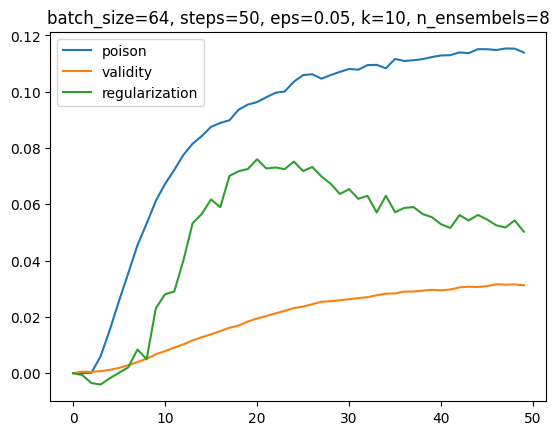

In [ ]:
plot_loss(loss, title=', '.join(f"{key}={value}" for key, value in args.items()))

"Validity":

In [ ]:
(
    ml_module.pred_fn(exp.cfs[jnp.array(exp.test_indices)]).round() == 
    ml_module.pred_fn(w_cfs).round()
).sum() / (w_cfs.shape[0] * w_cfs.shape[1] * 2) 

Array(0.9532, dtype=float32)

Original:

In [ ]:
relax.benchmark_cfs([exp])

,,acc,validity,proximity
Explanation,DiverseCF,0.9025,0.99654,0.933202


Watermarked:

In [ ]:
w_exp = exp.copy()
w_exp._cfs = w_exp.cfs.at[jnp.array(exp.test_indices)].set(w_cfs)
# exp.cfs.at[jnp.array(exp.test_indices)] = w_cfs
display(relax.benchmark_cfs([w_exp]))

,,acc,validity,proximity
Explanation,DiverseCF,0.9025,0.98524,0.971438


In [ ]:
# del exp
del w_exp
del w_cfs

## Pipeline

In [ ]:
from ipynb_path import *
from privacy.attack.extract import QueryModelExtraction, ModelExtractionCF, DualCFAttack, agreement
from scipy.stats import ttest_rel

In [ ]:
def generate_exp(
    cf_module: CFModule, # CF module used to generate CFs
    dm: DataModule, # Data module
    pred_fn: Callable[[Array], Array], # Model prediction function
    use_cached: bool = True, # Whether to use cached CFs
    cached_dir: str = 'experiments', # Directory to cache CFs
    rng_key: jrand.PRNGKey = jrand.PRNGKey(0), # Random number generator
) -> tuple[Explanation, CFModule]:
    """Generate CF explanations and save them to disk."""
    exp_dir = Path(cached_dir) / cf_module.name / dm.name

    if use_cached and exp_dir.exists():
        cf_module = prepare_cf_module(cf_module, dm, pred_fn=pred_fn)
        exp = Explanation.load_from_path(exp_dir)
        exp.pred_fn = pred_fn
    else:
        exp = relax.generate_cf_explanations(cf_module, dm, pred_fn=pred_fn, rng_key=rng_key)
        exp.save(exp_dir)
    return exp, cf_module

We have two problems:

1. **Overfitting**. The poison loss in the "training set" (during optimization) is 
larger than in the "test set" (during the detection).

2. **Undetectable**. The poison loss of extracted models using poisoned $D^\text{cf}$ 
is even smaller than extracted models without $D^\text{cf}$. 


In [ ]:
@dataclass
class PipelineOutput:
    exp: Explanation
    w_exp: Explanation
    cf_module: CFModule
    extracted_model: MLModule

In [ ]:
def pipeline(
    dm: DataModule,
    cf_module: CFModule,
    attack_fn: Callable, # Function to perform the attack
    n_queries: int, # Number of queries to the model
    ml_module: MLModule = None, # ML module
    w_batch_size: int = 1, # Batch size for watermarking
    train_kwargs: dict = None, # Keyword arguments for training the attack model
    use_cached: bool = False, # Whether to use cached CFs (TODO: Don't use this for now)
    use_watermark_to_extract: bool = True, # Whether to use watermarked explanations to extract the model
):
    # train ml model and generate cf explanations
    print("Training ML model for DataModule...")
    if ml_module is None:
        ml_module = relax.MLModule().train(dm, epochs=50, batch_size=32, verbose=0)
    print("Generating CF explanations...")
    exp, cf_module = generate_exp(
        cf_module, dm, ml_module.pred_fn, use_cached=use_cached
    )
    # 1. perform watermarking
    print("Performing watermarking...")
    net, params = keras2haiku(ml_module.model, ml_module.config, dm.xs[:1].shape)
    w_cfs, loss = batched_watermark(
        exp, pred_model=net, pred_params=params, 
        use_test_only=True, return_loss=True, 
        **args
    )
    train_indices, test_indices = map(jnp.array, (exp.train_indices, exp.test_indices))
    w_exp = exp.copy()
    w_exp._cfs = w_exp.cfs.at[test_indices].set(w_cfs)
    chex.assert_equal_shape([exp.cfs, w_exp.cfs])
    assert np.allclose(exp.cfs[train_indices], w_exp.cfs[train_indices])
    assert np.allclose(np.abs(exp.cfs[test_indices] - w_exp.cfs[test_indices]).max(), args['eps'])
    # plot loss
    plot_loss(loss, title=', '.join(f"{key}={value}" for key, value in args.items()))

    print("Validity: ", (
            ml_module.pred_fn(exp.cfs[test_indices]).round() == 
            ml_module.pred_fn(w_cfs).round()
        ).sum() / (w_cfs.shape[0] * w_cfs.shape[1] * 2) )
    
    print("Original CFs: ")
    display(relax.benchmark_cfs([exp]))
    print("Watermarked CFs: ")
    display(relax.benchmark_cfs([w_exp]))
    
    # 2. attack
    print("Performing model extraction attack...")
    if train_kwargs is None:
        train_kwargs = {
            'epochs': 100, 'validation_split': 0., 'batch_size': 32, 'verbose': False
        }

    extracted_model = attack_fn(
        w_exp if use_watermark_to_extract else exp, 
        n_queries=n_queries, train_kwargs=train_kwargs, shuffle=True
    )
    print("Extracted model agreement: ", 
          agreement(w_exp, extracted_model, w_exp['test']['xs']))
    
    # 3. detect watermark
    print("Detecting watermark...")
    w_cfs_ys = extracted_model.pred_fn(w_exp['test']['cfs'])
    cfs_ys = extracted_model.pred_fn(exp['test']['cfs'])
    # return w_cfs_ys, cfs_ys
    w_cfs_ys, cfs_ys = map(lambda x: x.reshape(-1, 2), (w_cfs_ys, cfs_ys))
    assert np.all(w_cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)] > 0.5)

    ttest = ttest_rel(
        w_cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)],
        cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)], 
        alternative="greater"
    )
    
    y_diff = np.mean(
        w_cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)] 
        - cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)]
    )

    print(f"p-value: {ttest[1]}, mean: {ttest[0]}")
    print(f"Poisson loss: {hard_kl_divergence(w_cfs_ys, cfs_ys).mean()}")
    print(f"Mean difference: {y_diff}")
    
    return PipelineOutput(
        exp=exp, w_exp=w_exp, cf_module=cf_module, extracted_model=extracted_model
    )

Training ML model for DataModule...
Generating CF explanations...


  0%|          | 0/1000 [00:00<?, ?it/s]

Performing watermarking...


  0%|          | 0/50 [00:00<?, ?it/s]

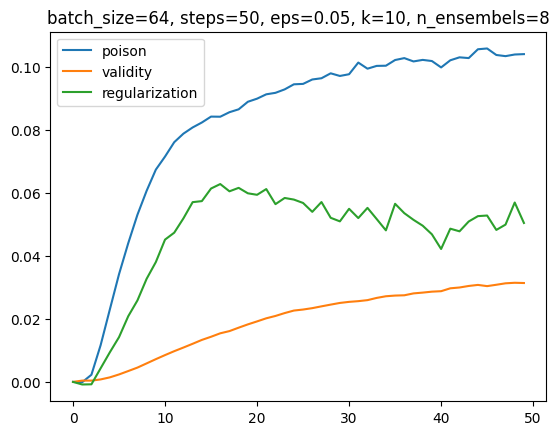

Validity:  0.95015997
Original CFs: 


,,acc,validity,proximity
Explanation,DiverseCF,0.9021,0.99604,0.926446


Watermarked CFs: 


,,acc,validity,proximity
Explanation,DiverseCF,0.9021,0.98406,0.966559


Performing model extraction attack...
Extracting model using 128 queries.
retrain_xs.shape: (768, 10); retrain_ys.shape: (768, 2)
Extracted model agreement:  0.95559996
Detecting watermark...
p-value: 0.0, mean: 81.06657691839155
Poisson loss: 0.09854990988969803
Mean difference: 0.06968893855810165


In [ ]:
model = MLModule({"loss": "binary_crossentropy", "metrics": ["accuracy"], 'lr': 0.01})
attack_fn = ModelExtractionCF(model)
cf_module = DiverseCF({'lambda_2': 4})

output = pipeline(
    dm=dm, 
    cf_module=cf_module, 
    attack_fn=attack_fn, 
    w_batch_size=32,
    ml_module=ml_module,
    n_queries=128, 
    train_kwargs={'epochs': 100, 'validation_split': 0., 'batch_size': 32, 'verbose': False}
)
# exp, w_exp, cf_module = pipeline(
#     dm=dm, 
#     cf_module=cf_module, 
#     attack_fn=attack_fn, 
#     n_queries=1000, 
#     train_kwargs={'epochs': 10, 'validation_split': 0., 'batch_size': 32, 'verbose': False}
# )

Training ML model for DataModule...
Generating CF explanations...


  0%|          | 0/1000 [00:00<?, ?it/s]

Performing watermarking...


  0%|          | 0/50 [00:00<?, ?it/s]

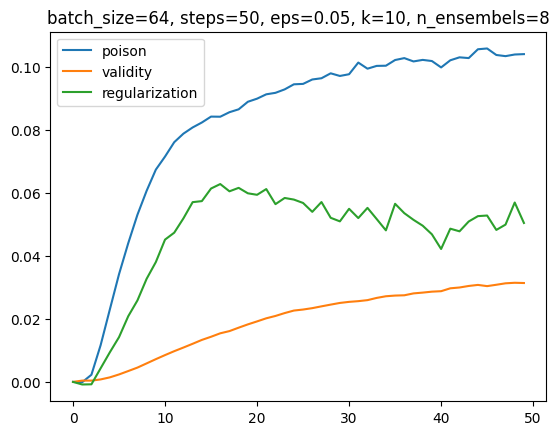

Validity:  0.95015997
Original CFs: 


,,acc,validity,proximity
Explanation,DiverseCF,0.9021,0.99604,0.926446


Watermarked CFs: 


,,acc,validity,proximity
Explanation,DiverseCF,0.9021,0.98406,0.966559


Performing model extraction attack...
Extracting model using 768 queries.
queried_xs.shape: (768, 10); queried_ys.shape: (768, 2)
Extracted model agreement:  0.97599995
Detecting watermark...
p-value: 6.795742952198652e-132, mean: 24.703706535927154
Poisson loss: 0.038267794996500015
Mean difference: 0.02451244555413723


In [ ]:
model = MLModule({"loss": "binary_crossentropy", "metrics": ["accuracy"], 'lr': 0.01})
attack_fn = QueryModelExtraction(model)
cf_module = DiverseCF({'lambda_2': 4})

query_output = pipeline(
    dm=dm, 
    cf_module=cf_module, 
    attack_fn=attack_fn, 
    w_batch_size=32,
    ml_module=ml_module,
    n_queries=128 * 6, 
    train_kwargs={'epochs': 100, 'validation_split': 0., 'batch_size': 64, 'verbose': False}
)

In [ ]:
del exp

In [ ]:
model = MLModule({"loss": "binary_crossentropy", "metrics": ["accuracy"], 'lr': 0.01})
attack_fn = ModelExtractionCF(model)
cf_module = DiverseCF({"lambda_1": 10.0})
dm = relax.load_data('adult')
dm = dm.set_transformations({
    f.name: 'gumbel' for f in dm.features if f.is_categorical
})
ml_module = relax.load_ml_module('adult')
args = dict(batch_size=64, steps=50, eps=0.05, k=10, n_ensembels=8)

output = pipeline(
    dm=dm, 
    cf_module=cf_module, 
    attack_fn=attack_fn, 
    w_batch_size=32,
    ml_module=ml_module,
    n_queries=128, 
    train_kwargs={'epochs': 100, 'validation_split': 0., 'batch_size': 32, 'verbose': False},
    use_watermark_to_extract=False
)


Training ML model for DataModule...
Generating CF explanations...


  0%|          | 0/1000 [00:00<?, ?it/s]

Performing watermarking...


2024-02-21 23:29:39.896146: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12.50GiB (rounded to 13417086464)requested by op 
2024-02-21 23:29:39.896271: W external/tsl/tsl/framework/bfc_allocator.cc:497] **__________________________________________________________________________________________________
2024-02-21 23:29:39.898394: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 13417086288 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    5.44MiB
              constant allocation:    5.42MiB
        maybe_live_out allocation:    4.60MiB
     preallocated temp allocation:   12.50GiB
                 total allocation:   12.51GiB
Peak buffers:
	Buffer 1:
		Size: 1.72GiB
		XLA Label: fusion
		Shape: f32[10,128,8,704,64]

	Buffer 2:
		Size: 1.72GiB
		Operator: op_name="jit(<unn

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 13417086288 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    5.44MiB
              constant allocation:    5.42MiB
        maybe_live_out allocation:    4.60MiB
     preallocated temp allocation:   12.50GiB
                 total allocation:   12.51GiB
Peak buffers:
	Buffer 1:
		Size: 1.72GiB
		XLA Label: fusion
		Shape: f32[10,128,8,704,64]
		==========================

	Buffer 2:
		Size: 1.72GiB
		Operator: op_name="jit(<unnamed function>)/jit(main)/vmap(jit(watermark))/while/body/jvp(jit(bilevel_fn))/broadcast_in_dim[shape=(10, 128, 8, 704, 64) broadcast_dimensions=()]" source_file="/tmp/ipykernel_1375/2298438799.py" source_line=80
		XLA Label: fusion
		Shape: f32[10,128,8,704,64]
		==========================

	Buffer 3:
		Size: 880.00MiB
		XLA Label: fusion
		Shape: f32[10,128,8,704,32]
		==========================

	Buffer 4:
		Size: 880.00MiB
		Operator: op_name="jit(<unnamed function>)/jit(main)/vmap(jit(watermark))/while/body/jvp(jit(bilevel_fn))/broadcast_in_dim[shape=(10, 128, 8, 704, 32) broadcast_dimensions=()]" source_file="/tmp/ipykernel_1375/2298438799.py" source_line=80
		XLA Label: fusion
		Shape: f32[10,128,8,704,32]
		==========================

	Buffer 5:
		Size: 440.00MiB
		XLA Label: fusion
		Shape: pred[10,128,8,704,64]
		==========================

	Buffer 6:
		Size: 440.00MiB
		XLA Label: fusion
		Shape: pred[10,128,8,704,64]
		==========================

	Buffer 7:
		Size: 440.00MiB
		XLA Label: fusion
		Shape: f32[10,128,8,704,16]
		==========================

	Buffer 8:
		Size: 440.00MiB
		Operator: op_name="jit(<unnamed function>)/jit(main)/vmap(jit(watermark))/while/body/jvp(jit(bilevel_fn))/broadcast_in_dim[shape=(10, 128, 8, 704, 16) broadcast_dimensions=()]" source_file="/tmp/ipykernel_1375/2298438799.py" source_line=80
		XLA Label: fusion
		Shape: f32[10,128,8,704,16]
		==========================

	Buffer 9:
		Size: 440.00MiB
		Operator: op_name="jit(<unnamed function>)/jit(main)/vmap(jit(watermark))/while/body/jvp(jit(bilevel_fn))/broadcast_in_dim[shape=(10, 128, 8, 704, 64) broadcast_dimensions=()]" source_file="/tmp/ipykernel_1375/2298438799.py" source_line=80
		XLA Label: fusion
		Shape: pred[10,128,8,704,64]
		==========================

	Buffer 10:
		Size: 220.00MiB
		XLA Label: fusion
		Shape: pred[10,128,8,704,32]
		==========================

	Buffer 11:
		Size: 220.00MiB
		XLA Label: fusion
		Shape: pred[10,128,8,704,32]
		==========================

	Buffer 12:
		Size: 220.00MiB
		Operator: op_name="jit(<unnamed function>)/jit(main)/vmap(jit(watermark))/while/body/jvp(jit(bilevel_fn))/broadcast_in_dim[shape=(10, 128, 8, 704, 32) broadcast_dimensions=()]" source_file="/tmp/ipykernel_1375/2298438799.py" source_line=80
		XLA Label: fusion
		Shape: pred[10,128,8,704,32]
		==========================

	Buffer 13:
		Size: 110.00MiB
		XLA Label: fusion
		Shape: pred[10,128,8,704,16]
		==========================

	Buffer 14:
		Size: 110.00MiB
		XLA Label: fusion
		Shape: pred[10,128,8,704,16]
		==========================

	Buffer 15:
		Size: 110.00MiB
		Operator: op_name="jit(<unnamed function>)/jit(main)/vmap(jit(watermark))/while/body/jvp(jit(bilevel_fn))/broadcast_in_dim[shape=(10, 128, 8, 704, 16) broadcast_dimensions=()]" source_file="/tmp/ipykernel_1375/2298438799.py" source_line=80
		XLA Label: fusion
		Shape: pred[10,128,8,704,16]
		==========================



In [ ]:
ext_model = query_output.extracted_model
ext_model.pred_fn(query_output.exp['test']['cfs'])[:2]

Array([[[0.77056485, 0.22943513],
        [0.4689529 , 0.53104717],
        [0.76602423, 0.2339758 ],
        [0.5049798 , 0.49502018],
        [0.7781878 , 0.22181219]],

       [[0.32245973, 0.6775403 ],
        [0.2588478 , 0.74115217],
        [0.1675924 , 0.83240753],
        [0.838106  , 0.16189398],
        [0.31967527, 0.68032473]]], dtype=float32)

In [ ]:
ext_model.pred_fn(query_output.w_exp['test']['cfs'])[:2]

Array([[[0.95203805, 0.04796195],
        [0.6447441 , 0.35525596],
        [0.9487889 , 0.05121104],
        [0.6707016 , 0.32929838],
        [0.93486625, 0.06513373]],

       [[0.83064705, 0.169353  ],
        [0.6858471 , 0.31415293],
        [0.50126255, 0.49873748],
        [0.9946765 , 0.00532353],
        [0.7247351 , 0.2752649 ]]], dtype=float32)

In [ ]:
w_cfs_ys = w_cfs_ys.reshape(-1, 2)
cfs_ys = cfs_ys.reshape(-1, 2)

ttest = ttest_rel(
    w_cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)], 
    cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)], 
    alternative="greater"
)
ttest

TtestResult(statistic=97.28104352179284, pvalue=0.0, df=12499)

In [ ]:
np.mean(
    w_cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)] 
    - cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)]
)

Array(0.07796965, dtype=float32)

In [ ]:
ttest

TtestResult(statistic=68.30160603965514, pvalue=0.0, df=12499)

In [ ]:
w_cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)][:50]

Array([0.98034006, 0.9152052 , 0.90355223, 0.9846305 , 0.9737616 ,
       0.97130275, 0.9817516 , 0.95691055, 0.9695619 , 0.92364615,
       0.80405474, 0.8070021 , 0.67727226, 0.50853974, 0.5987384 ,
       0.9705121 , 0.7628358 , 0.96570754, 0.91923875, 0.65237975,
       0.9463949 , 0.95180005, 0.93798584, 0.9658393 , 0.9813766 ,
       0.9937731 , 0.94671834, 0.99452704, 0.99835914, 0.99298286,
       0.9897467 , 0.985639  , 0.94025815, 0.9320132 , 0.9846746 ,
       0.9689686 , 0.9518641 , 0.934813  , 0.9600013 , 0.94085807,
       0.972187  , 0.94878846, 0.95941925, 0.96386504, 0.97489375,
       0.92221797, 0.9643498 , 0.8571041 , 0.8731993 , 0.92533493],      dtype=float32)

In [ ]:
cfs_ys[jnp.arange(w_cfs_ys.shape[0]), w_cfs_ys.argmax(axis=1)][:50]

Array([0.9220309 , 0.8558917 , 0.84937066, 0.9148746 , 0.9530671 ,
       0.8854167 , 0.9321706 , 0.92728215, 0.92162687, 0.93260205,
       0.5685385 , 0.60189664, 0.551676  , 0.47335315, 0.60719824,
       0.93475646, 0.60192275, 0.8816081 , 0.88396436, 0.5731258 ,
       0.95452857, 0.9513335 , 0.9038653 , 0.95526   , 0.9533894 ,
       0.98080826, 0.96608716, 0.9863783 , 0.9937784 , 0.9543886 ,
       0.9719688 , 0.9757597 , 0.9350506 , 0.93018967, 0.9757506 ,
       0.9069906 , 0.9066185 , 0.8789286 , 0.9099944 , 0.8821037 ,
       0.93972063, 0.90264076, 0.9178585 , 0.94201964, 0.9389882 ,
       0.9166412 , 0.8936177 , 0.92257726, 0.8973405 , 0.91254133],      dtype=float32)

## WIP

In [ ]:
def watermark(
    xs: jax.Array, # original sample (B, K)
    cfs: jax.Array, # counterfactual (B, C, K)
    pred_model: hk.Transformed, # predictive model
    watermarker: hk.Transformed, # watermarker model
    pred_params: hk.Params, # predictive model parameters
    wm_params: hk.Params, # watermarker model parameters
    pred_opt: optax.GradientTransformation, # predictive model optimizer
    wm_opt: optax.GradientTransformation, # watermarker model optimizer
    steps: int, # number of outer steps
    k: int, # number of inner steps
    n_ensembels: int, # number of ensembels
    rng_key: jax.random.PRNGKey, # random key
    proj_fn: Callable = lambda x: x, # projection function
):
    # TODO: Still buggy
    def inner_fn(weights, batch, rng):
        inputs, labels = batch
        logits = pred_model.apply(weights, rng, inputs, is_training=True)
        loss = L.binary_crossentropy(labels, logits).mean()
        return loss

    def inner_step(i, state):
        pred_w, wm_w, pred_opt_state, rng = state
        key, next_key = jrand.split(rng)
        # inner problem: model extraction attack with xs and watermarked cfs
        w_cfs = watermarker.apply(wm_w, None, cfs, is_training=False)
        w_xs = jnp.concatenate([xs, w_cfs]) # (B + B * C, K)
        w_ys = jnp.concatenate([
            pred_model.apply(pred_params, jrand.PRNGKey(0), xs, is_training=False),
            pred_model.apply(pred_params, jrand.PRNGKey(0), w_cfs, is_training=False)
        ])
        loss, g = jax.value_and_grad(inner_fn)(pred_w, (w_xs, w_ys), key)
        # clip very small gradients to avoid nan
        g = jax.tree_map(
            lambda x: jnp.where(
                jnp.abs(x) < 1e-8, jnp.zeros_like(x), x
            ), g
        )
        pred_w, pred_opt_state = pred_opt.update(g, pred_opt_state, pred_w)
        return pred_w, wm_w, pred_opt_state, next_key

    def bilevel_fn(wm_w, pred_w, rng): 
        # loop through k inner steps to get extracted models
        pred_opt_state = pred_opt.init(pred_w)
        upt_pred_w, wm_w, pred_opt_state, rng = jax.lax.fori_loop(
            0, k, inner_step, (pred_w, wm_w, pred_opt_state, rng))
        # outer problem: model watermarking
        key, next_key = jrand.split(rng)
        # watermarked cfs
        w_cfs = watermarker.apply(wm_w, key, cfs, is_training=True)
        # poison loss: max divergence between watermarked cfs and cfs in the updated model
        w_cfs_y_updated = pred_model.apply(upt_pred_w, jrand.PRNGKey(0), w_cfs, is_training=False)
        cfs_y_updated = pred_model.apply(upt_pred_w, jrand.PRNGKey(0), cfs, is_training=False)
        poison_loss = hard_kl_divergence(w_cfs_y_updated, cfs_y_updated).mean()
        # validity loss: min divergence between watermarked cfs and cfs in the original model
        w_cfs_y_old = pred_model.apply(pred_params, jrand.PRNGKey(0), w_cfs, is_training=False)
        cfs_y_old = pred_model.apply(pred_params, jrand.PRNGKey(0), cfs, is_training=False)
        validity_loss = L.kl_divergence(w_cfs_y_old, cfs_y_old).mean()
        loss = (poison_loss - validity_loss) # maximize poison loss and minimize validity loss
        return loss, (upt_pred_w, next_key, (poison_loss, validity_loss))
    
    def outer_step(state, i):
        pred_w, wm_w, wm_opt_state, rng = state
        (_, (pred_w, key, loss)), g = jax.value_and_grad(
            bilevel_fn, has_aux=True)(wm_w, pred_w, rng)
        wm_w, wm_opt_state = grad_update(g, wm_w, wm_opt_state, wm_opt)
        wm_w = proj_fn(wm_w)
        return (pred_w, wm_w, wm_opt_state, key), loss
    
    # reshape xs and cfs
    xs_shape = einops.parse_shape(xs, 'B K')
    cfs = einops.rearrange(cfs, 'B C K -> (B C) K', **xs_shape)
    # init optimizers
    wm_opt_state = wm_opt.init(wm_params)
    state = (pred_params, wm_params, wm_opt_state, rng_key)
    # loop through steps
    (pred_params, wm_params, wm_opt_state, _), loss = jax.lax.scan(
        outer_step, state, jnp.arange(steps))
    # get watermarked cfs
    w_cfs = watermarker.apply(wm_params, jrand.PRNGKey(0), cfs, is_training=False)
    w_cfs = einops.rearrange(w_cfs, '(B C) K -> B C K', **xs_shape)
    return w_cfs, loss

In [ ]:
def _pad_divisible_xs(xs: Array, n: int):
    """Pad `X` to be divisible by `n`."""
    if xs.shape[0] % n != 0:
        pad_size = n - xs.shape[0] % n
        xs_pad = einops.repeat(
            xs[-1:], "n ... -> (pad n) ...", pad=pad_size
        )
        xs = jnp.concatenate([xs, xs_pad])
    X_padded = xs.reshape(-1, n, *xs.shape[1:])
    return X_padded


In [ ]:
def scale_sign() -> optax.GradientTransformation:
    """Apply the sign of the gradient to the update."""

    def init_fn(param):
        del param
        return optax.EmptyState()
    
    def update_fn(updates, state, params=None):
        del params
        updates = jax.tree_util.tree_map(lambda g: jnp.sign(g), updates)
        return updates, state

    return optax.GradientTransformation(init_fn, update_fn)

def linf_proj(x, eps: float):
    return jax.tree_util.tree_map(
        lambda x: jnp.clip(x, -eps, eps), x
    )

def watermarker_fn(x, is_training=False):
    delta = hk.get_parameter(
        'delta', (1, x.shape[-1]), dtype=x.dtype, 
        init=hk.initializers.RandomUniform(-eps, eps)
    )
    return x + delta

eps = 0.03
steps = 25
wm_opt = optax.chain(
    optax.scale_by_adam(),
    scale_sign(),
    optax.scale(2.5 * eps / steps)
)
watermarker = hk.transform(watermarker_fn)
wm_params = watermarker.init(jrand.PRNGKey(0), dm.xs[:1])
wm_opt_state = wm_opt.init(wm_params)

partial_watermark = partial(
    watermark, 
    pred_model=pred_model, 
    watermarker=watermarker,
    pred_params=pred_params, 
    wm_params=wm_params,
    pred_opt=optax.adam(1e-1),
    wm_opt=wm_opt,
    steps=steps, k=5, n_ensembels=1, rng_key=jrand.PRNGKey(0),
    proj_fn=ft.partial(linf_proj, eps=eps)
)
bs = 32
# w_cfs, loss = partial_watermark(exp.xs[:bs], exp.cfs[:bs, :, :])
# plot_loss(jax.tree_util.tree_map(lambda x: x.reshape(1, -1), loss))

In [ ]:
xs_pad, cfs_pad = jax.tree_map(
    lambda arr: _pad_divisible_xs(arr, 32), (xs, exp.cfs)
)
partial_watermark = partial(watermark, pred_model=pred_model, 
                            watermarker=watermarker, pred_params=pred_params, 
                            wm_params=wm_params, pred_opt=optax.adam(1e-1),
                            wm_opt=wm_opt, steps=steps, k=5, n_ensembels=1, 
                            rng_key=jrand.PRNGKey(0), proj_fn=ft.partial(linf_proj, eps=eps))
                            # train_xs=dm.xs[jnp.array(exp.train_indices)])
w_cfs, loss = jax.vmap(partial_watermark)(xs_pad, cfs_pad)

In [ ]:
def loss_fn(delta, x, y, rng_key):
    # inv = inverse_softmax(multiplicative_replacement(x))
    # x_hat = jax.nn.softmax(inv + delta)
    # x_hat = gumbel_softmax(rng_key, x + delta, tau=0.1)
    # return L.categorical_crossentropy(y, x_hat).mean()
    x_hat = x + delta
    return L.mean_squared_error(y, x_hat).mean()

# x = jnp.array([[0., 0., 1.], [0., 0., 1.]])
# y = jnp.array([[1., 0., 0.], [1., 0., 0.]])
x = np.random.rand(2, 3)
y = np.random.rand(2, 3)
rng_key = jrand.PRNGKey(0)
delta = jrand.uniform(rng_key, shape=x.shape)
# delta = jnp.zeros_like(x)
opt = optax.adam(0.1)
opt_state = opt.init(delta)

for _ in range(10):
    rng_key, _ = jrand.split(rng_key)
    grad = jax.grad(loss_fn)(delta, x, y, rng_key)
    updates, opt_state = opt.update(grad, opt_state)
    delta = optax.apply_updates(delta, updates)

loss_fn(delta, x, y, rng_key)


Array(0.02759915, dtype=float32)

## Deprecated

In [ ]:
@ft.partial(jax.jit, static_argnums=(3, 6, 8, 9, 12, 13, 14))
def watermark(
    x: jax.Array, # original sample (B, K)
    y: jax.Array, # original label (B, 1)
    cf: jax.Array, # counterfactual (B, C, K)
    net,
    params: hk.Params,
    lr: float,
    steps: int,
    step_size: float, # 2.5 * eps / steps
    k: int,
    n_ensembels: int,
    rng_key: jax.random.PRNGKey,
    train_xs: jax.Array,
    init_fn: Callable,
    proj_fn: Callable, # project function for delta
    apply_constraints: Callable, # apply constraints to the counterfactual
):
        
    def forward(weights, key, xs, is_training):
        return jax.vmap(net.apply, in_axes=(0, None, None, None))(
            weights, key, xs, is_training
        )
    
    def vapply_constraints(cf, hard):
        cf = einops.rearrange(cf, '(B C) K -> B C K', **x_shape)
        cf = jax.vmap(apply_constraints, in_axes=(None, 1, None), out_axes=1)(x, cf, hard)
        return einops.rearrange(cf, 'B C K -> (B C) K', **x_shape)

    @jax.jit
    def inner_fn(weights, batch, key):
        xs, ys = batch
        # f_w, adv model
        y_pred = net.apply(weights, key, xs, is_training=True)
        loss = L.binary_crossentropy(ys, y_pred).mean()
        return loss

    @ft.partial(jax.jit, static_argnums=(6,))
    def bilevel_fn(delta, new_params, old_params, opt_state, key, batch, opt):
        def inner_step_fn(i, state):
            """inner steps"""

            delta, params, opt_state, key = state
            key, next_key = jrand.split(key)

            w_cf = vapply_constraints(cf + delta, hard=False)
            batch_size = cf.shape[0]
            # use more data for training for improved generalization
            # more_train_xs = train_xs[i * batch_size: (i + 1) * batch_size]
            more_train_xs = jax.lax.dynamic_slice(
                train_xs, (i * batch_size, 0), (batch_size, train_xs.shape[-1]))
            xs = jnp.concatenate([x, more_train_xs, w_cf])
            # xs = jnp.concatenate([w_cf])
            ys = net.apply(old_params, jrand.PRNGKey(0), xs, is_training=False)
            # TODO: when params equals to old_params, the gradient is zero (seems okay)
            loss, g = jax.vmap(jax.value_and_grad(inner_fn), (0, None, None))(params, (xs, ys), key)
            # clip very small gradients to avoid nan
            g = jax.tree_map(
                lambda x: jnp.where(
                    jnp.abs(x) < 1e-8, jnp.zeros_like(x), x
                ), g
            )
            params, opt_state = grad_update(g, params, opt_state, opt)
            return delta, params, opt_state, next_key
    
        x, y, cf = batch
        
        # inner problem
        delta, new_params, opt_state, key = jax.lax.fori_loop(
            0, k, inner_step_fn, (delta, new_params, opt_state, key))

        # outer problem
        w_cf = vapply_constraints(cf + delta, hard=False)
        _cf_y_updated = forward(new_params, jrand.PRNGKey(0), w_cf, is_training=False)
        cf_y_updated = forward(new_params, jrand.PRNGKey(0), cf, is_training=False)
        _cf_y_old = net.apply(old_params, jrand.PRNGKey(0), w_cf, is_training=False)
        cf_y_old = net.apply(old_params, jrand.PRNGKey(0), cf, is_training=False)
        
        # loss functions
        poison_loss = hard_kl_divergence(_cf_y_updated, cf_y_updated).mean()
        validity_loss = L.kl_divergence(_cf_y_old, cf_y_old).mean()
        loss = (poison_loss - validity_loss)
        return loss, (new_params, opt_state, key, (poison_loss, validity_loss))
        
    @scan_tqdm(steps)
    def step_fn(state, i):
        delta, params, old_params, opt_state, key = state
        ((_, (params, opt_state, key, loss)), g) = jax.value_and_grad(
            bilevel_fn, has_aux=True)(
                delta, params, old_params, opt_state, key, (x, y, cf), opt) # ((value, auxiliary_data), gradient)
        # print("loss: ", loss)

        # delta = delta + (2.5 * eps / steps) * jnp.sign(g)
        delta = delta + step_size * jnp.sign(g)
        # delta = jnp.clip(delta, -eps, eps)
        delta = proj_fn(delta)

        # reinit params
        key, reinit_key = jrand.split(key)
        # params = reinit_params(params, reinit_key, x[:1])
        return (delta, params, old_params, opt_state, key), loss

    # reshape x and cf
    x_shape = einops.parse_shape(x, 'B K')
    cf = einops.rearrange(cf, 'B C K -> (B C) K', **x_shape)
    # split keys
    rng_key, init_delta_key, init_params_key = jrand.split(rng_key, 3)
    # init delta
    # delta = jrand.uniform(jrand.PRNGKey(0), shape=cf.shape, minval=-eps, maxval=eps)
    delta = init_fn(init_delta_key, cf.shape)
    # delta = jnp.zeros_like(cf)
    # init params
    # old_params = copy.deepcopy(params)
    old_params = params
    keys = jrand.split(init_params_key, n_ensembels)
    new_params = jax.vmap(net.init, in_axes=(0, None, None))(keys, x[:1], True)
    opt = optax.adam(lr)
    opt_state = opt.init(new_params)
    
    # new_params = net.init(jrand.PRNGKey(0), x[:1], is_training=True)
    # new_params = params
    state = (delta, new_params, old_params, opt_state, rng_key)
    (delta, new_params, old_params, opt_state, _), loss = jax.lax.scan(
        step_fn, state, jnp.arange(steps)
    )
    cf = vapply_constraints(cf + delta, True)
    cf = einops.rearrange(cf, '(B C) K -> B C K', **x_shape)
    return cf, loss

In [ ]:
def watermark(
    x: jnp.Array, # original sample (B, K)
    y: jnp.Array, # original label (B, 1)
    cf: jnp.Array, # counterfactual (B, C, K)
    net,
    params: hk.Params,
    lr: float,
    steps: int,
    eps: float, # max perturbation
    k: int,
    rng_key=jrand.PRNGKey(0)
):
    @jax.jit
    def inner_fn(params, batch, key):
        xs, ys = batch
        # f_w, adv model
        y_pred = net.apply(params, key, xs, is_training=True)
        loss = L.binary_crossentropy(ys, y_pred).mean()
        return loss

    @ft.partial(jax.jit, static_argnums=(6,))
    def bilevel_fn(delta, params, old_params, opt_state, key, batch, opt):
        def inner_step_fn(i, state):
            """inner steps"""

            delta, params, opt_state, key = state
            key, next_key = jrand.split(key)

            _cf = cf + delta
            xs = jnp.concatenate([x, _cf])
            ys = jnp.concatenate([
                net.apply(old_params, jrand.PRNGKey(0), x, is_training=False),
                # use watermarked cf
                net.apply(old_params, jrand.PRNGKey(0), _cf, is_training=False)
            ])
            # TODO: when params equals to old_params, the gradient is zero (seems okay)
            loss, g = jax.value_and_grad(inner_fn)(params, (xs, ys), key)
            # clip very small gradients to avoid nan
            g = jax.tree_map(
                lambda x: jnp.where(
                    jnp.abs(x) < 1e-8, jnp.zeros_like(x), x
                ), g
            )
            params, opt_state = grad_update(g, params, opt_state, opt)
            return delta, params, opt_state, next_key
    
        x, y, cf = batch
        
        # inner problem
        # for i in range(k):
        #     delta, params, opt_state, key = inner_step_fn(i, (delta, params, opt_state, key))
        delta, params, opt_state, key = jax.lax.fori_loop(
            0, k, inner_step_fn, (delta, params, opt_state, key))

        # outer problem
        _cf_y_updated = net.apply(params, jrand.PRNGKey(0), cf + delta, is_training=False)
        cf_y_updated = net.apply(params, jrand.PRNGKey(0), cf, is_training=False)
        _cf_y_old = net.apply(old_params, jrand.PRNGKey(0), cf  + delta, is_training=False)
        cf_y_old = net.apply(old_params, jrand.PRNGKey(0), cf, is_training=False)
        
        # loss functions
        # poison_loss = L.kl_divergence(_cf_y_updated, cf_y_updated).mean()
        poison_loss = hard_kl_divergence(_cf_y_updated, cf_y_updated).mean()
        validity_loss = L.kl_divergence(_cf_y_old, cf_y_old).mean()
        # loss = (
        #     L.kl_divergence(_cf_y_updated, cf_y_updated) 
        #     - L.kl_divergence(_cf_y_old, cf_y_old)
        # ).mean()
        loss = (poison_loss - validity_loss)
        return loss, (params, opt_state, key, (poison_loss, validity_loss))
    
    @scan_tqdm(steps)
    def step_fn(state, i):
        delta, params, old_params, opt_state, key = state
        ((_, (params, opt_state, key, loss)), g) = jax.value_and_grad(
            bilevel_fn, has_aux=True)(
                delta, params, old_params, opt_state, key, (x, y, cf), opt) # ((value, auxiliary_data), gradient)
        # print("loss: ", loss)
        
        delta = delta + (2.5 * eps / steps) * jnp.sign(g)
        delta = jnp.clip(delta, -eps, eps)
        return (delta, params, old_params, opt_state, key), loss

    
    # reshape x and cf
    x_shape = einops.parse_shape(x, 'B K')
    cf = einops.rearrange(cf, 'B C K -> (B C) K', **x_shape)
    # init delta
    delta = jrand.uniform(jrand.PRNGKey(0), shape=cf.shape, minval=-eps, maxval=eps)
    # delta = jnp.zeros_like(cf)
    opt = optax.adam(lr)
    opt_state = opt.init(params)
    #TODO: init f_param to F_param (is this correct?)
    # old_params = copy.deepcopy(params)
    old_params = params
    new_params = net.init(jrand.PRNGKey(0), x[:1], is_training=True)
    # new_params = params
    state = (delta, new_params, old_params, opt_state, rng_key)
    # for i in range(steps):
    #     state = step_fn(i, state)
    # delta, params, old_params, opt_state, _ = jax.lax.fori_loop(0, steps, step_fn, state)
    (delta, new_params, old_params, opt_state, _), loss = jax.lax.scan(
        step_fn, state, jnp.arange(steps)
    )
    cf = cf + delta
    cf = einops.rearrange(cf, '(B C) K -> B C K', **x_shape)
    return cf, loss